In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import sys
sys.path.append("../../")
from src.util import operators
from src.util.stochastic_expectation_value import compute_stochastic_expectation_value_linear as compute_exp_val
from src.homps import homps
from src.hops import hops

In [5]:
# parameters for the bath correlation functions
g = np.array([2])
w = np.array([0.5+2j])
# time
duration = 50
# operators
sigma_x, sigma_z, eye = operators.generate_physical_operators()
h = operators.generate_spin_boson_hamiltonian()
L = sigma_z

Without noise:


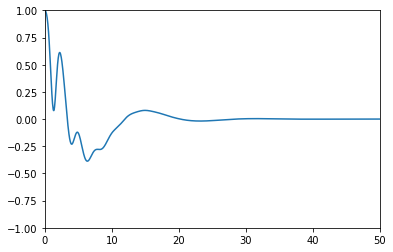

With noise:


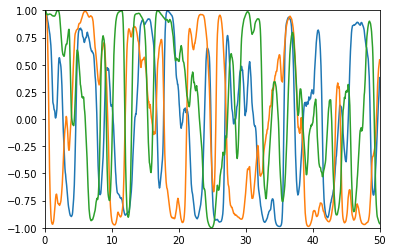

In [13]:
N_steps = 1000
N_trunc = 8
options = {
    'linear' : True,
    'use_noise' : False,
    'method' : 'RK4',
    'chi_max' : 10,
    'eps' : 1.e-15
}

print("Without noise:")
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
psis = my_homps.compute_realizations(1)
sigma_zs = compute_exp_val(psis, sigma_z)
plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

print("With noise:")
options['use_noise'] = True
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)
for i in range(3):
    psis = my_homps.compute_realizations(1)
    sigma_zs = compute_exp_val(psis, sigma_z)
    plt.plot(np.linspace(0, duration, N_steps), sigma_zs, "-")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

In [42]:
N_steps = 1000
N_trunc = 16
options = {
    'linear' : True,
    'use_noise' : True,
    'method' : 'RK4',
    'chi_max' : 10,
    'eps' : 1.e-15
}

In [43]:
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)

In [44]:
psis_100 = my_homps.compute_realizations(N_samples=100, progressBar=tqdm)

  0%|          | 0/100 [00:00<?, ?it/s]

In [45]:
sigma_zs_100 = compute_exp_val(psis_100, sigma_z)
#sigma_zs_1000 = compute_exp_val(psis_1000, sigma_z)

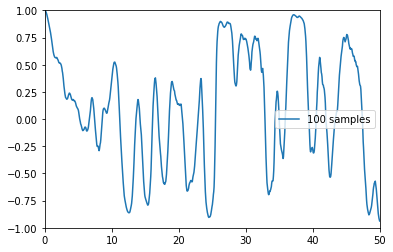

In [46]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_100, label="100 samples")
#plt.plot(np.linspace(0, duration, N_steps), sigma_zs_1000, label="1000 samples")
plt.legend(loc="right")
plt.ylim(-1, 1)
plt.xlim(0, duration)
plt.show()

# Fine-tuned comparison

In [86]:
N_steps = 10000
N_trunc = 55
options = {
    'linear' : True,
    'use_noise' : True,
    'method' : 'RK4',
    'chi_max' : 10,
    'eps' : 1.e-15
}

In [87]:
options['method'] = 'Trotter'
my_hops = hops.HOPS_Engine_Simple(g, w, h, L, duration, N_steps, N_trunc, options)
options['method'] = 'RK4'
my_homps = homps.HOMPS_Engine(g, w, h, L, duration, N_steps, N_trunc, options)

In [88]:
zts = my_hops.generator.sample_process()
#zts = None

In [89]:
psis_hops = my_hops.compute_realizations(1, zts_debug=zts)
psis_homps = my_homps.compute_realizations(1, zts_debug=zts)

In [90]:
sigma_zs_hops = compute_exp_val(psis_hops, sigma_z)
sigma_zs_homps = compute_exp_val(psis_homps, sigma_z)

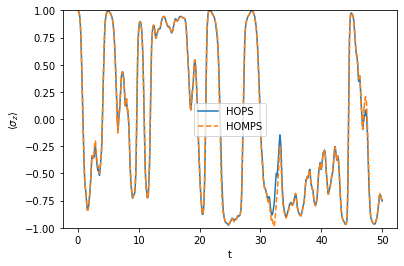

In [91]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_hops, label="HOPS")
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_homps, "--", label="HOMPS")
plt.ylabel(r"$\left\langle\sigma_z\right\rangle$")
plt.xlabel("t")
plt.legend()
plt.ylim(-1, 1)
plt.show()

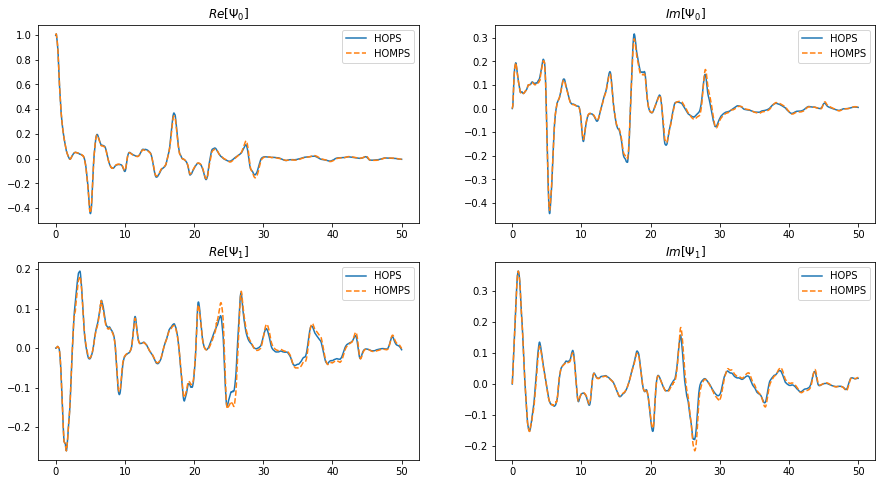

In [93]:
figure, axarray = plt.subplots(2, 2, figsize=(15, 8))

axarray[0][0].plot(np.linspace(0, duration, N_steps), np.real(psis_hops[0, :, 0]), label="HOPS")
axarray[0][0].plot(np.linspace(0, duration, N_steps), np.real(psis_homps[0, :, 0]), "--", label="HOMPS")
axarray[0][0].legend()
axarray[0][0].set_title(r"$Re\left[\Psi_0\right]$")

axarray[0][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_hops[0, :, 0]), label="HOPS")
axarray[0][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_homps[0, :, 0]), "--", label="HOMPS")
axarray[0][1].legend()
axarray[0][1].set_title(r"$Im\left[\Psi_0\right]$")

axarray[1][0].plot(np.linspace(0, duration, N_steps), np.real(psis_hops[0, :, 1]), label="HOPS")
axarray[1][0].plot(np.linspace(0, duration, N_steps), np.real(psis_homps[0, :, 1]), "--", label="HOMPS")
axarray[1][0].legend()
axarray[1][0].set_title(r"$Re\left[\Psi_1\right]$")

axarray[1][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_hops[0, :, 1]), label="HOPS")
axarray[1][1].plot(np.linspace(0, duration, N_steps), np.imag(psis_homps[0, :, 1]), "--", label="HOMPS")
axarray[1][1].legend()
axarray[1][1].set_title(r"$Im\left[\Psi_1\right]$")

plt.show()

Still is mostly converged at N_trunc = 55, but needs more N_steps to converge (error of RK is higher). We
might be able to fix this by using the Hamiltonian MPO at t+dt/2 and t+dt steps?

# Sanity check: does the norm of HOPS just grow exponentially?

In [88]:
hops = hops_trotter_simple.HOPS_Simple_Trotter(g, w, h, L, duration, N_steps, N_trunc, linear=True, use_noise=False, N_krylov=N_krylov)

In [89]:
psis_hops = hops.compute_realizations(1, zts_debug=zts)

norm: 1.002426617714978
norm: 1.0095879886558226
norm: 1.021726726957115
norm: 1.039675588030496
norm: 1.065008398274102
norm: 1.1003984323072973
norm: 1.1503909324547974
norm: 1.2231553320140505
norm: 1.3349821095289958
norm: 1.5244107316052082
norm: 1.9119723942764846
norm: 3.0121697435022603
norm: 6.954803608095168
norm: 20.190933788454643
norm: 58.85875319933319
norm: 158.28833844011712
norm: 384.62717104402446
norm: 842.6032016078093
norm: 1669.737452792546
norm: 3007.973322553211
norm: 4952.047905117163
norm: 7488.170516706964
norm: 10449.00984101077
norm: 13512.138107348694
norm: 16254.690868310812
norm: 18252.528747033815
norm: 19190.460843919354
norm: 18943.33198021305
norm: 17599.764687401865
norm: 15424.331249759274
norm: 12777.363857798167
norm: 10023.840646212766
norm: 7460.4332311905055
norm: 5277.022442360792
norm: 3553.622911595574
norm: 2282.4865124127537
norm: 1401.0941208209824
norm: 823.8210182691595
norm: 465.2293003372126
norm: 253.16673214960122
norm: 133.3564324

norm: 0.09186310716094631
norm: 0.09114746768825724
norm: 0.09043788238473613
norm: 0.08973428985082733
norm: 0.08903662494994809
norm: 0.08834481932545629
norm: 0.08765880201585835
norm: 0.08697850003331131
norm: 0.08630383880149661
norm: 0.08563474280115582
norm: 0.0849711361438986
norm: 0.0843129428408037
norm: 0.08366008727801226
norm: 0.08301249481070426
norm: 0.08237009201881493
norm: 0.08173280690868992
norm: 0.08110056931921679
norm: 0.080473311228045
norm: 0.07985096689357007
norm: 0.0792334729630204
norm: 0.07862076858484654
norm: 0.0780127956494142
norm: 0.07740949887310211
norm: 0.07681082555902752
norm: 0.07621672564736078
norm: 0.07562715196761781
norm: 0.07504206000916917
norm: 0.0744614076167555
norm: 0.07388515508186906
norm: 0.07331326512016607
norm: 0.07274570257443516
norm: 0.0721824342550072
norm: 0.07162342882017139
norm: 0.07106865655167949
norm: 0.07051808926272271
norm: 0.0699717001601425
norm: 0.06942946351305208
norm: 0.06889135447537863
norm: 0.0683573490593

norm: 0.007653342960177827
norm: 0.007594177444036804
norm: 0.007535469335346222
norm: 0.007477215091749628
norm: 0.007419411201243479
norm: 0.007362054189975777
norm: 0.007305140605398021
norm: 0.007248667009998623
norm: 0.0071926300003414285
norm: 0.007137026209774969
norm: 0.007081852289345248
norm: 0.007027104907780092
norm: 0.0069727807677225934
norm: 0.006918876602173383
norm: 0.006865389164339458
norm: 0.006812315229599151
norm: 0.006759651598588781
norm: 0.006707395100753297
norm: 0.006655542593044501
norm: 0.006604090950040488
norm: 0.006553037066792252
norm: 0.006502377871227497
norm: 0.006452110317474273
norm: 0.006402231373387309
norm: 0.00635273802968943
norm: 0.006303627310370454
norm: 0.006254896260942619
norm: 0.006206541940420457
norm: 0.0061585614345915874
norm: 0.006110951858455541
norm: 0.00606371034279094
norm: 0.006016834038560573
norm: 0.005970320126620971
norm: 0.005924165807032705
norm: 0.005878368294330372
norm: 0.0058329248287458295
norm: 0.005787832676724306

norm: 0.0007065454531085166
norm: 0.0007010834587523652
norm: 0.0006956636886405659
norm: 0.0006902858162211269
norm: 0.0006849495177896191
norm: 0.0006796544721063266
norm: 0.0006744003600729571
norm: 0.0006691868651830018
norm: 0.0006640136737055981
norm: 0.0006588804739809989
norm: 0.0006537869565556514
norm: 0.0006487328149077998
norm: 0.000643717744816453
norm: 0.0006387414439609187
norm: 0.0006338036126490678
norm: 0.0006289039536929191
norm: 0.0006240421718482662
norm: 0.0006192179741144596
norm: 0.0006144310702470664
norm: 0.00060968117211839
norm: 0.0006049679931334615
norm: 0.0006002912495025367
norm: 0.0005956506601187912
norm: 0.0005910459450437411


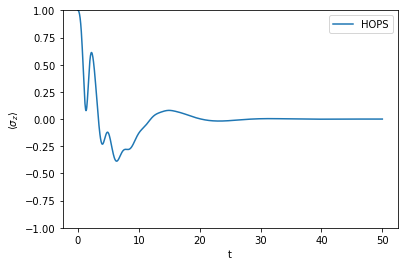

In [87]:
plt.plot(np.linspace(0, duration, N_steps), sigma_zs_hops, label="HOPS")
plt.ylabel(r"$\left\langle\sigma_z\right\rangle$")
plt.xlabel("t")
plt.legend()
plt.ylim(-1, 1)
plt.show()